# Comparing Clustering methods in Customer Segementation 

In [ ]:
# Mount drive to have access to the data This can be removed in the final 
# version of the notebook this is only needed for colab
from google.colab import drive
drive.mount('/content/drive')
!pip install matplotlib==3.4.3

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import colors

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering

from yellowbrick.cluster import KElbowVisualizer

from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings('ignore')
np.random.seed(120)

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/marketing_campaign.csv", sep="\t")
data.head()

ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0  

[5 rows x 29 columns]

 # Handling Missing Data And Preprocessing

 We need to first in order to do any data preprocessing, deal with missing data. Included is a helpful graphic created by youtuber data professor

![Dealing With Missing Data](https://pbs.twimg.com/media/FNUKTOmVgAEhFz3?format=jpg)

The first thing, which should be looked at is the columns, according to the descriptions available from the source of the dataset, [here](https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis/). The two columns **Z_Revenue**, **Z_CostContact** have the same data in each record and do not add any informaiton and can be dropped. This we can confirm by checking for unique values in those rows before dropping them, we are dropping them to prior to modifying the dataset further so they do not get in the way.

In [ ]:
print('Column: Unique Values')
for col in data:
  print(f'{col}: {len(data[col].unique())}')

# since those 2 columns only have 1 unqiue value we can drop them

data = data.drop(columns=['Z_Revenue', 'Z_CostContact', 'ID'])

Column: Unique Values
ID: 2240
Year_Birth: 59
Education: 5
Marital_Status: 8
Income: 1975
Kidhome: 3
Teenhome: 3
Dt_Customer: 663
Recency: 100
MntWines: 776
MntFruits: 158
MntMeatProducts: 558
MntFishProducts: 182
MntSweetProducts: 177
MntGoldProds: 213
NumDealsPurchases: 15
NumWebPurchases: 15
NumCatalogPurchases: 14
NumStorePurchases: 14
NumWebVisitsMonth: 16
AcceptedCmp3: 2
AcceptedCmp4: 2
AcceptedCmp5: 2
AcceptedCmp1: 2
AcceptedCmp2: 2
Complain: 2
Z_CostContact: 1
Z_Revenue: 1
Response: 2


Lets first look at the information of the dataset, this can give us a better look into the data we are working with. For this we will just preform a simple listwise deletion for any data which is missing.

In [ ]:
data.info()
data = data.dropna() # This is the listwise deletion
print('\n After performing listwise deletion. \n')
print(f"Records after listwise deletion {len(data)}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year_Birth           2240 non-null   int64  
 1   Education            2240 non-null   object 
 2   Marital_Status       2240 non-null   object 
 3   Income               2216 non-null   float64
 4   Kidhome              2240 non-null   int64  
 5   Teenhome             2240 non-null   int64  
 6   Dt_Customer          2240 non-null   object 
 7   Recency              2240 non-null   int64  
 8   MntWines             2240 non-null   int64  
 9   MntFruits            2240 non-null   int64  
 10  MntMeatProducts      2240 non-null   int64  
 11  MntFishProducts      2240 non-null   int64  
 12  MntSweetProducts     2240 non-null   int64  
 13  MntGoldProds         2240 non-null   int64  
 14  NumDealsPurchases    2240 non-null   int64  
 15  NumWebPurchases      2240 non-null   i

### Lets look at the summary statistics of the data we will be using during the dimensionality reduction.

In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
data.drop(['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response'], axis=1).describe()

Year_Birth    Income  Kidhome  Teenhome  Recency  MntWines  MntFruits  \
count     2216.00   2216.00  2216.00   2216.00  2216.00   2216.00    2216.00   
mean      1968.82  52247.25     0.44      0.51    49.01    305.09      26.36   
std         11.99  25173.08     0.54      0.54    28.95    337.33      39.79   
min       1893.00   1730.00     0.00      0.00     0.00      0.00       0.00   
25%       1959.00  35303.00     0.00      0.00    24.00     24.00       2.00   
50%       1970.00  51381.50     0.00      0.00    49.00    174.50       8.00   
75%       1977.00  68522.00     1.00      1.00    74.00    505.00      33.00   
max       1996.00 666666.00     2.00      2.00    99.00   1493.00     199.00   

       MntMeatProducts  MntFishProducts  MntSweetProducts  MntGoldProds  \
count          2216.00          2216.00           2216.00       2216.00   
mean            167.00            37.64             27.03         43.97   
std             224.28            54.75             41.07         51.82   
min               0.00             0.00              0.00          0.00   
25%              16.00             3.00              1.00          9.00   
50%              68.00            12.00              8.00         24.50   
75%             232.25            50.00             33.00         56.00   
max            1725.00           259.00            262.00        321.00   

       NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  \
count            2216.00          2216.00              2216.00   
mean                2.32             4.09                 2.67   
std                 1.92             2.74                 2.93   
min                 0.00             0.00                 0.00   
25%                 1.00             2.00                 0.00   
50%                 2.00             4.00                 2.00   
75%                 3.00             6.00                 4.00   
max                15.00            27.00                28.00   

       NumStorePurchases  NumWebVisitsMonth  
count            2216.00            2216.00  
mean                5.80               5.32  
std                 3.25               2.43  
min                 0.00               0.00  
25%                 3.00               3.00  
50%                 5.00               6.00  
75%                 8.00               7.00  
max                13.00              20.00

Now that we have removed data which is not necessary for analysis we can continue to do some preprocessing, turning categorical data into numerical values which can be used.
First we will take the dt_customer and turn it into a integer of how long they have been a customer with a 0 for the newest customer and days from that date as the others.

In [ ]:
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"])
max_date = max(data["Dt_Customer"])
data["Customer_For"] = data["Dt_Customer"].apply(lambda x: max_date.date() - x.date())
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors="coerce")

In [ ]:
# join martial status and make it a categoritcal column
data["Marital_Status"] = data["Marital_Status"].replace({"Together":"Married", "Absurd":"Single", "YOLO":"Single", "Alone": "Single", "Maried": "Married"})
data["Marital_Status"] = pd.Categorical(data["Marital_Status"]) 

# adding the number of teens and kids home to create a total number of children in the house hold
data["Children"] = data["Kidhome"] + data["Teenhome"] 

# setting the age of the custer based on when the dataset was created (max date of custeromer membership)
data["Age"] = max_date.year-data["Year_Birth"] 

# Thte total  spend at the grocery store based on everything spent at the store
data["Spent"] = data["MntWines"] + data["MntFruits"] + data["MntMeatProducts"] + data["MntFishProducts"] + data["MntSweetProducts"] + data["MntGoldProds"]

# a temp to count for marital status and then the total size of the family of the customer
data["Living_With"] = data["Marital_Status"].replace({"Married": 2,  "Widow": 1, "Divorced": 1, "Single": 1})
data["Family_Size"] = data["Living_With"] + data["Children"]

# a true false for parent status
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

# simplify the Education category and turn it into a categoritcal column
data["Education"] = data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})
data["Education"] = pd.Categorical(data["Education"]) 

# rename columns to make it more simple to understand
data = data.rename(columns={"MntWines": "SpentOnWines","MntFruits":"SpentOnFruits","MntMeatProducts":"SpentOnMeat","MntFishProducts":"SpentOnFish","MntSweetProducts":"SpentOnSweets","MntGoldProds":"SpentOnGold"})

# drop unnecessary columns
data = data.drop(columns=["Dt_Customer", "Living_With", "Year_Birth"])

Lets see the summary statisitics of the data, this will allow us to see any unusual data such as outliers

In [ ]:
data.describe()

Income  Kidhome  Teenhome  Recency  SpentOnWines  SpentOnFruits  \
count   2216.00  2216.00   2216.00  2216.00       2216.00        2216.00   
mean   52247.25     0.44      0.51    49.01        305.09          26.36   
std    25173.08     0.54      0.54    28.95        337.33          39.79   
min     1730.00     0.00      0.00     0.00          0.00           0.00   
25%    35303.00     0.00      0.00    24.00         24.00           2.00   
50%    51381.50     0.00      0.00    49.00        174.50           8.00   
75%    68522.00     1.00      1.00    74.00        505.00          33.00   
max   666666.00     2.00      2.00    99.00       1493.00         199.00   

       SpentOnMeat  SpentOnFish  SpentOnSweets  SpentOnGold  ...  \
count      2216.00      2216.00        2216.00      2216.00  ...   
mean        167.00        37.64          27.03        43.97  ...   
std         224.28        54.75          41.07        51.82  ...   
min           0.00         0.00           0.00         0.00  ...   
25%          16.00         3.00           1.00         9.00  ...   
50%          68.00        12.00           8.00        24.50  ...   
75%         232.25        50.00          33.00        56.00  ...   
max        1725.00       259.00         262.00       321.00  ...   

       AcceptedCmp1  AcceptedCmp2  Complain  Response         Customer_For  \
count       2216.00       2216.00   2216.00   2216.00              2216.00   
mean           0.06          0.01      0.01      0.15 44237345848375448.00   
std            0.24          0.12      0.10      0.36 20085324558024976.00   
min            0.00          0.00      0.00      0.00                 0.00   
25%            0.00          0.00      0.00      0.00 29376000000000000.00   
50%            0.00          0.00      0.00      0.00 44323200000000000.00   
75%            0.00          0.00      0.00      0.00 59270400000000000.00   
max            1.00          1.00      1.00      1.00 91843200000000000.00   

       Children     Age   Spent  Family_Size  Is_Parent  
count   2216.00 2216.00 2216.00      2216.00    2216.00  
mean       0.95   45.18  607.08         2.59       0.71  
std        0.75   11.99  602.90         0.91       0.45  
min        0.00   18.00    5.00         1.00       0.00  
25%        0.00   37.00   69.00         2.00       0.00  
50%        1.00   44.00  396.50         3.00       1.00  
75%        1.00   55.00 1048.00         3.00       1.00  
max        3.00  121.00 2525.00         5.00       1.00  

[8 rows x 28 columns]

We can also look at graphing the data to see if there are any other outliers.

In [ ]:
# Color settings for graphing 
sns.set(rc={"axes.facecolor":"#ffd4c3","figure.facecolor":"#ffd4c3"})
pallet = ["#131B23", "#d41b2c", "#e05143", "#ea755e", "#f3967c", "#fab59e"]
cmap = colors.ListedColormap(["#131B23", "#d41b2c", "#e05143", "#ea755e", "#f3967c", "#fab59e"])

<Figure size 576x396 with 0 Axes>

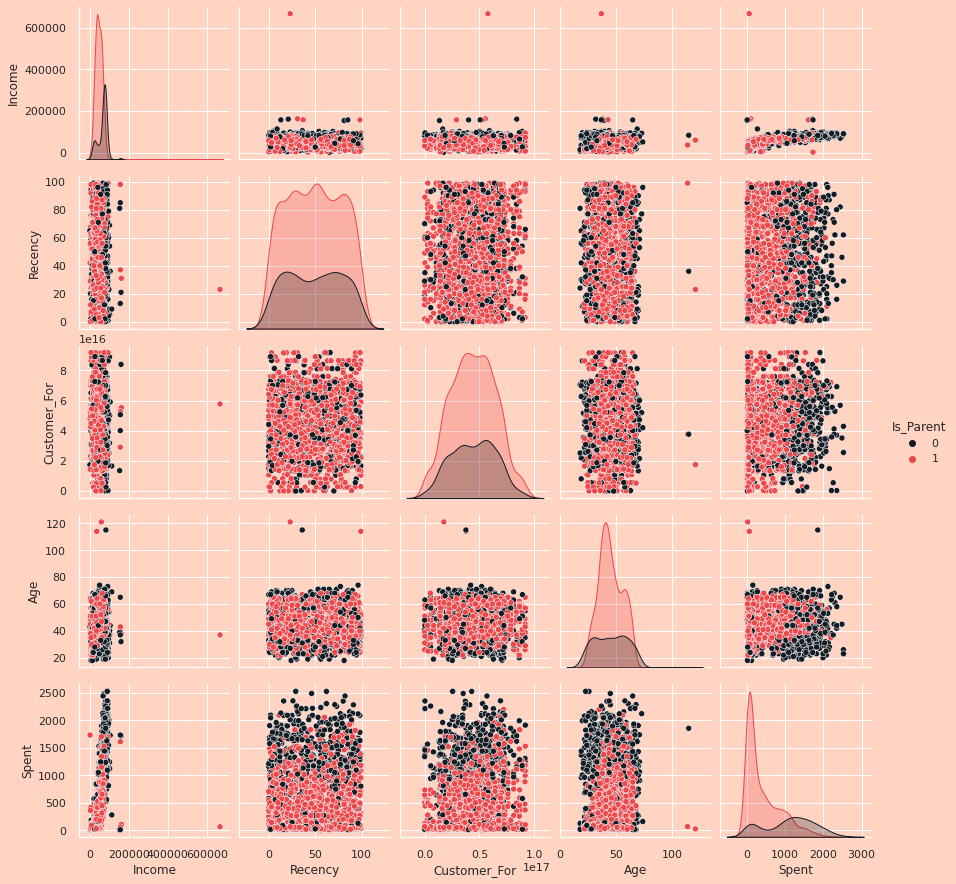

In [ ]:
# Lets plot some of the columns
To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
plt.figure()
sns.pairplot(data[To_Plot], hue= "Is_Parent",palette= (["#131B23","#ED474A"]))
plt.show()

We can see there are outliers in Income and Age so we can remove them thorugh listwise deletion.

In [ ]:
# Preform listwise deletion on the outlier data.
data = data[(data["Age"]<90)]
data = data[(data["Income"]<600000)]
print(f"Number of entries after listwise deletion: {len(data)}" )

Number of entries after listwise deletion: 2212


<AxesSubplot:>

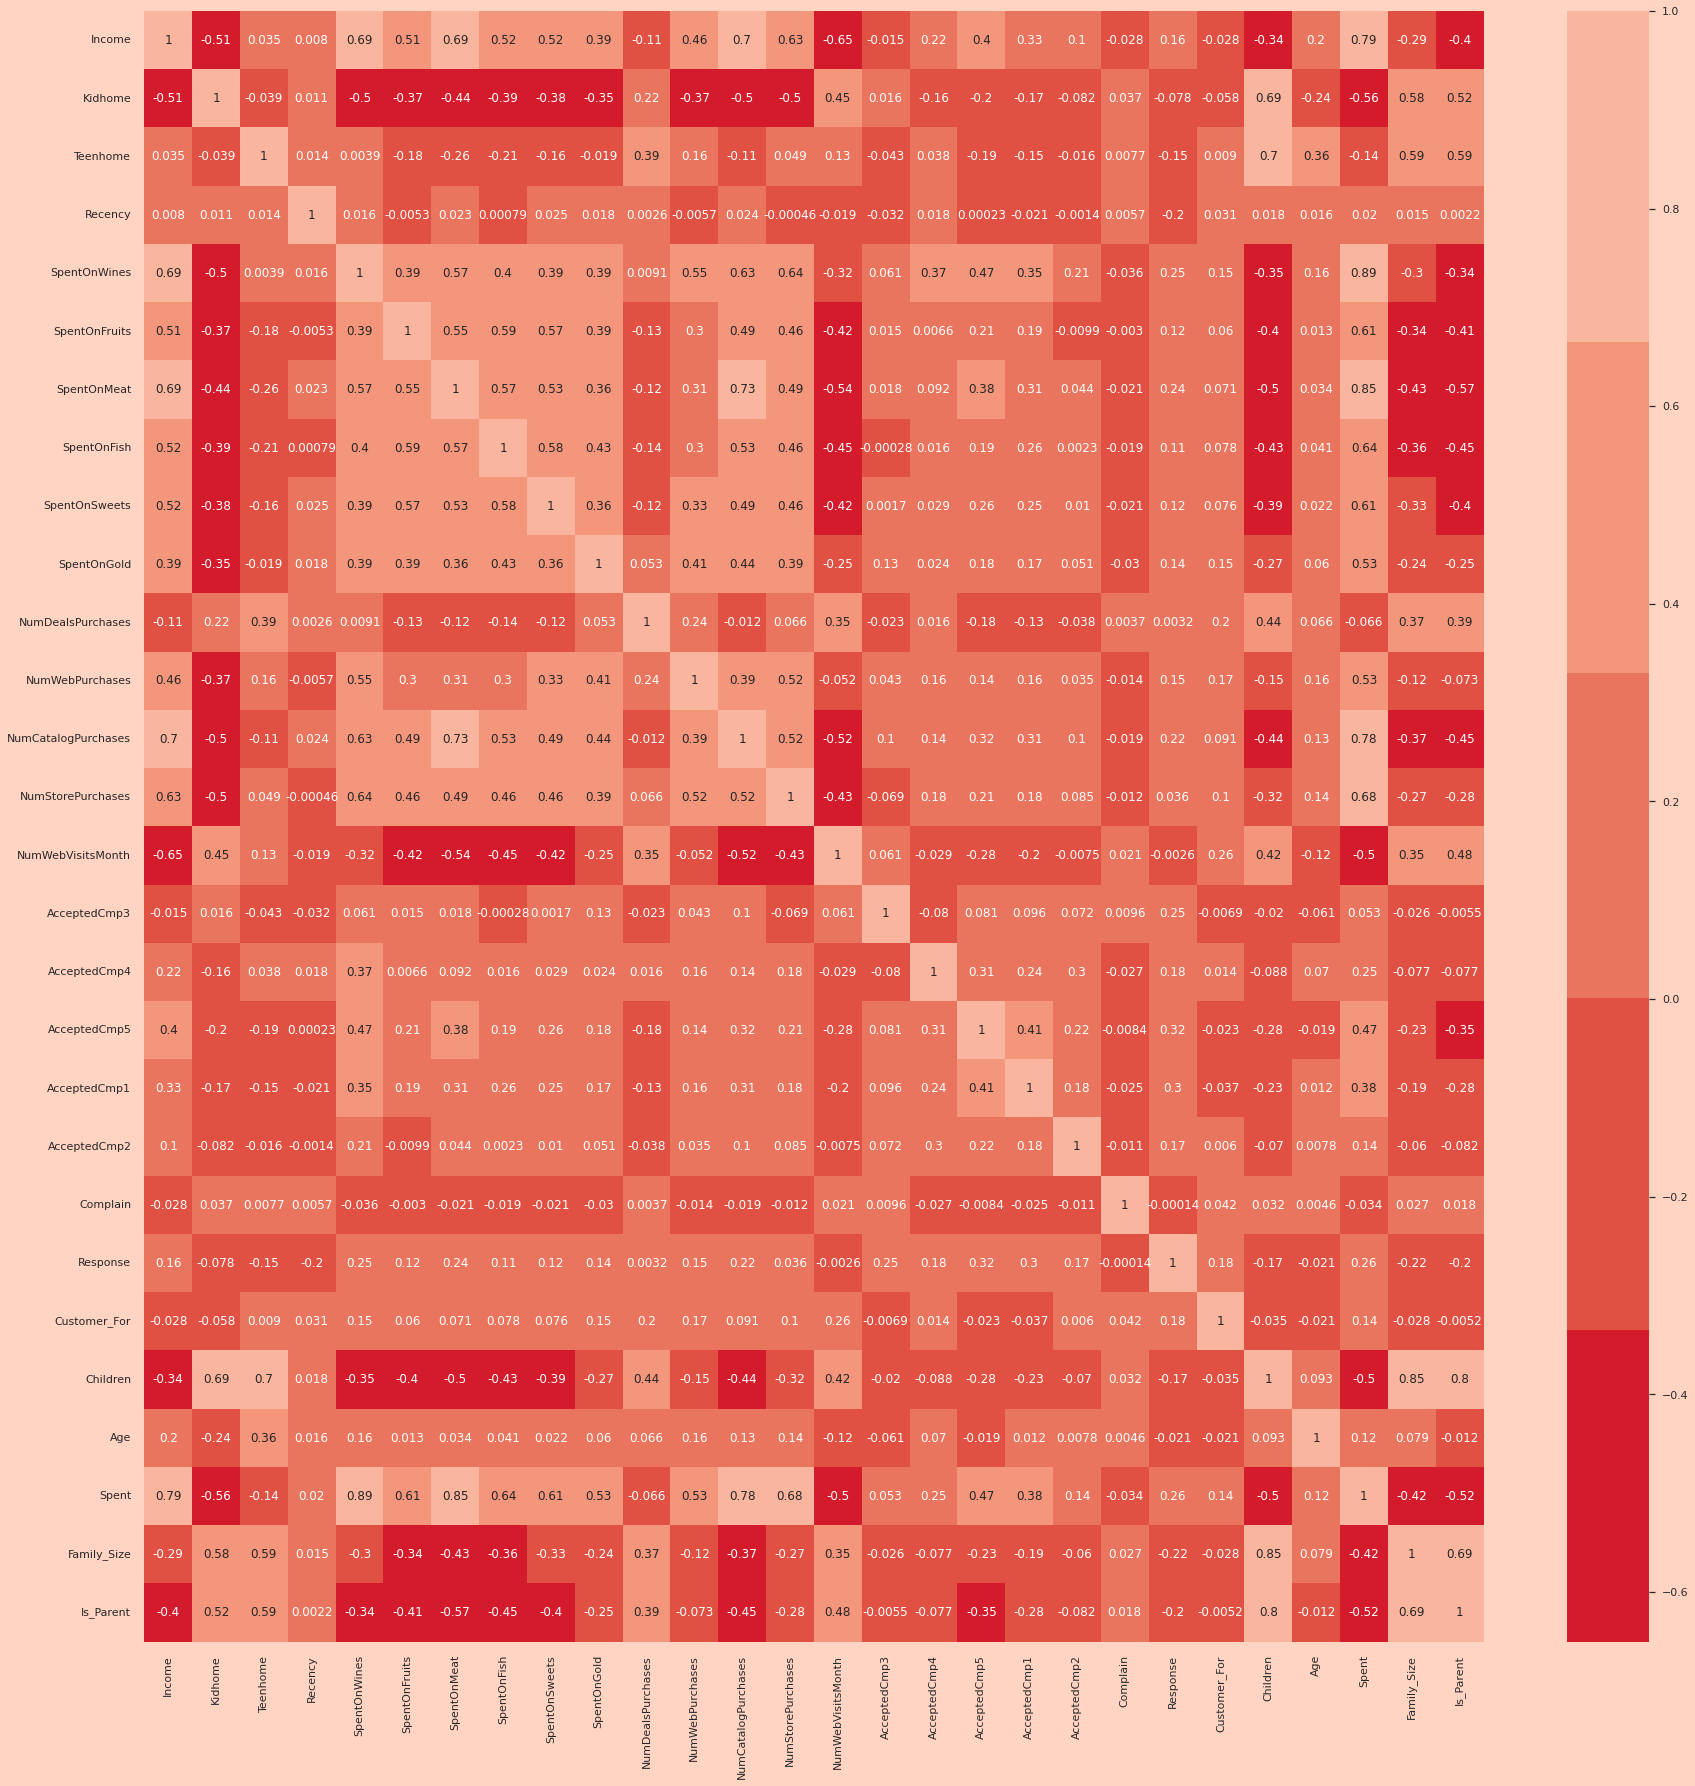

In [ ]:
corrmat= data.corr()
plt.figure(figsize=(30,30))  
sns.heatmap(corrmat, annot=True, cmap=cmap, center=0)

In [ ]:


# Lets turn each of the categorical columns into numerical data
s = (data.dtypes == 'category')
object_cols = list(s[s].index)

LE=LabelEncoder()
for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2212 entries, 0 to 2239
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2212 non-null   int64  
 1   Marital_Status       2212 non-null   int64  
 2   Income               2212 non-null   float64
 3   Kidhome              2212 non-null   int64  
 4   Teenhome             2212 non-null   int64  
 5   Recency              2212 non-null   int64  
 6   SpentOnWines         2212 non-null   int64  
 7   SpentOnFruits        2212 non-null   int64  
 8   SpentOnMeat          2212 non-null   int64  
 9   SpentOnFish          2212 non-null   int64  
 10  SpentOnSweets        2212 non-null   int64  
 11  SpentOnGold          2212 non-null   int64  
 12  NumDealsPurchases    2212 non-null   int64  
 13  NumWebPurchases      2212 non-null   int64  
 14  NumCatalogPurchases  2212 non-null   int64  
 15  NumStorePurchases    2212 non-null   i

We can then scale the data to make clustering easier for the algorithm.



In [ ]:
#Creating a copy of data
ds = data.copy()
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)
#Scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )

In [ ]:
#Scaled data to be used for reducing the dimensionality
scaled_ds.head()

Education  Marital_Status  Income  Kidhome  Teenhome  Recency  \
0      -0.89            1.26    0.29    -0.82     -0.93     0.31   
1      -0.89            1.26   -0.26     1.04      0.91    -0.38   
2      -0.89           -0.28    0.91    -0.82     -0.93    -0.80   
3      -0.89           -0.28   -1.18     1.04     -0.93    -0.80   
4       0.57           -0.28    0.29     1.04     -0.93     1.55   

   SpentOnWines  SpentOnFruits  SpentOnMeat  SpentOnFish  ...  \
0          0.98           1.55         1.69         2.45  ...   
1         -0.87          -0.64        -0.72        -0.65  ...   
2          0.36           0.57        -0.18         1.34  ...   
3         -0.87          -0.56        -0.66        -0.50  ...   
4         -0.39           0.42        -0.22         0.15  ...   

   NumWebPurchases  NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  \
0             1.43                 2.50              -0.56               0.69   
1            -1.13                -0.57              -1.17              -0.13   
2             1.43                -0.23               1.29              -0.54   
3            -0.76                -0.91              -0.56               0.28   
4             0.33                 0.11               0.06              -0.13   

   Customer_For  Children   Age  Spent  Family_Size  Is_Parent  
0          1.97     -1.26  1.02   1.68        -1.76      -1.58  
1         -1.67      1.40  1.27  -0.96         0.45       0.63  
2         -0.17     -1.26  0.33   0.28        -0.65      -1.58  
3         -1.92      0.07 -1.29  -0.92         0.45       0.63  
4         -0.82      0.07 -1.03  -0.31         0.45       0.63  

[5 rows x 23 columns]

# Dimesntionality Reduction
Preform PCA to do dimensionality reduction to 3 columns. 

In [ ]:
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

count  mean  std   min   25%   50%  75%  max
col1 2212.00 -0.00 2.88 -5.96 -2.54 -0.78 2.37 7.46
col2 2212.00  0.00 1.70 -4.26 -1.33 -0.17 1.25 6.09
col3 2212.00  0.00 1.21 -3.33 -0.87 -0.00 0.81 6.35

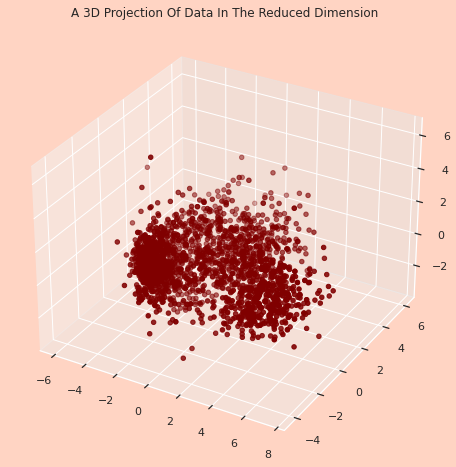

In [ ]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

Lets use the elbow method (knee point detection) to decide how many cluster we should have. 

Elbow Method to determine the number of clusters to be formed:


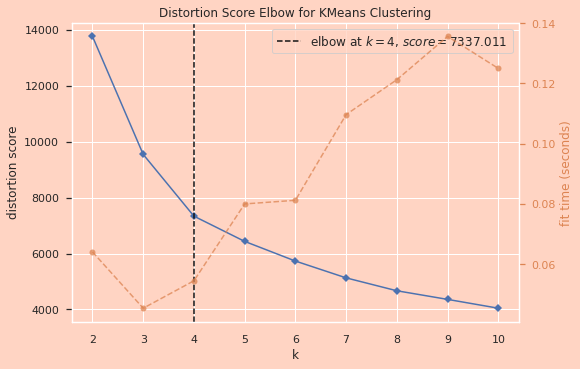

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

Lets create the clusters and evaluate the clusters creared by different methods agglomatic, kmeans through minibatch, and spectral clustering. 

In [ ]:

#Initiating the Agglomerative Clustering model 
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["AC_Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
data["AC_Clusters"]= yhat_AC

In [ ]:
#Initiating the KMeans Clustering model 
KM = KMeans(n_clusters=4)
# fit model and predict clusters
yhat_KM = KM.fit_predict(PCA_ds)
PCA_ds["KM_Clusters"] = yhat_KM
#Adding the Clusters feature to the orignal dataframe.
data["KM_Clusters"]= yhat_KM

In [ ]:
#Initiating the Spectral Clustering model 
SC = SpectralClustering(n_clusters=4)
# fit model and predict clusters
yhat_SC = SC.fit_predict(PCA_ds)
PCA_ds["SC_Clusters"] = yhat_SC
#Adding the Clusters feature to the orignal dataframe.
data["SC_Clusters"]= yhat_SC

In [ ]:
cluster_labels = ["SC_Clusters", "KM_Clusters", "AC_Clusters"]

## Compare Clusters to see if there is a meaningful difference

In [ ]:

# lets do the count first
for label in cluster_labels:
  print(data[label].value_counts())

0    699
1    616
3    482
2    415
Name: SC_Clusters, dtype: int64
2    674
1    617
3    482
0    439
Name: KM_Clusters, dtype: int64
0    729
1    612
3    468
2    403
Name: AC_Clusters, dtype: int64


In [ ]:
data.loc[data["KM_Clusters"]== 2].describe() 

Education  Marital_Status    Income  Kidhome  Teenhome  Recency  \
count     674.00          674.00    674.00   674.00    674.00   674.00   
mean        0.60            1.14  45795.74     0.68      1.01    48.07   
std         0.63            0.64  13600.02     0.58      0.31    29.29   
min         0.00            0.00   4023.00     0.00      0.00     0.00   
25%         0.00            1.00  37296.50     0.00      1.00    24.00   
50%         1.00            1.00  45904.50     1.00      1.00    49.00   
75%         1.00            1.00  54155.75     1.00      1.00    73.00   
max         2.00            3.00 162397.00     2.00      2.00    99.00   

       SpentOnWines  SpentOnFruits  SpentOnMeat  SpentOnFish  ...  Response  \
count        674.00         674.00       674.00       674.00  ...    674.00   
mean         138.88           6.29        42.33         8.69  ...      0.08   
std          144.43          11.36        42.69        13.08  ...      0.28   
min            1.00           0.00         1.00         0.00  ...      0.00   
25%           25.25           0.00        11.00         0.00  ...      0.00   
50%           81.50           2.00        26.00         4.00  ...      0.00   
75%          209.75           7.00        64.00        11.00  ...      0.00   
max          734.00         123.00       253.00        82.00  ...      1.00   

              Customer_For  Children    Age   Spent  Family_Size  Is_Parent  \
count               674.00    674.00 674.00  674.00       674.00     674.00   
mean  39900648071216616.00      1.70  49.30  225.04         3.38       1.00   
std   20189958045959300.00      0.59   9.08  196.55         0.73       0.00   
min      86400000000000.00      1.00  32.00    8.00         2.00       1.00   
25%   23306400000000000.00      1.00  42.00   54.00         3.00       1.00   
50%   38404800000000000.00      2.00  49.00  160.50         3.00       1.00   
75%   54324000000000000.00      2.00  57.00  376.00         4.00       1.00   
max   88819200000000000.00      3.00  68.00 1019.00         5.00       1.00   

       AC_Clusters  KM_Clusters  SC_Clusters  
count       674.00       674.00       674.00  
mean          0.03         2.00         0.00  
std           0.16         0.00         0.00  
min           0.00         2.00         0.00  
25%           0.00         2.00         0.00  
50%           0.00         2.00         0.00  
75%           0.00         2.00         0.00  
max           1.00         2.00         0.00  

[8 rows x 33 columns]

In [ ]:
data.loc[data["AC_Clusters"]== 0].describe() 

Education  Marital_Status    Income  Kidhome  Teenhome  Recency  \
count     729.00          729.00    729.00   729.00    729.00   729.00   
mean        0.60            1.14  46501.37     0.70      0.98    48.47   
std         0.63            0.65  13863.19     0.57      0.39    29.10   
min         0.00            0.00   4023.00     0.00      0.00     0.00   
25%         0.00            1.00  37758.00     0.00      1.00    24.00   
50%         1.00            1.00  46098.00     1.00      1.00    49.00   
75%         1.00            1.00  54456.00     1.00      1.00    73.00   
max         2.00            3.00 162397.00     2.00      2.00    99.00   

       SpentOnWines  SpentOnFruits  SpentOnMeat  SpentOnFish  ...  Response  \
count        729.00         729.00       729.00       729.00  ...    729.00   
mean         165.08           7.86        52.43        10.40  ...      0.10   
std          185.53          14.16        56.68        15.73  ...      0.30   
min            1.00           0.00         1.00         0.00  ...      0.00   
25%           28.00           0.00        12.00         0.00  ...      0.00   
50%           98.00           3.00        32.00         4.00  ...      0.00   
75%          238.00           9.00        76.00        13.00  ...      0.00   
max         1459.00         123.00       487.00       123.00  ...      1.00   

              Customer_For  Children    Age   Spent  Family_Size  Is_Parent  \
count               729.00    729.00 729.00  729.00       729.00     729.00   
mean  41513718518518520.00      1.68  48.58  270.84         3.35       1.00   
std   20828640430642868.00      0.59   9.49  254.63         0.75       0.00   
min      86400000000000.00      1.00  24.00    8.00         2.00       1.00   
25%   25228800000000000.00      1.00  41.00   61.00         3.00       1.00   
50%   40867200000000000.00      2.00  48.00  211.00         3.00       1.00   
75%   56419200000000000.00      2.00  57.00  417.00         4.00       1.00   
max   91670400000000000.00      3.00  68.00 1750.00         5.00       1.00   

       AC_Clusters  KM_Clusters  SC_Clusters  
count       729.00       729.00       729.00  
mean          0.00         1.84         0.09  
std           0.00         0.50         0.38  
min           0.00         0.00         0.00  
25%           0.00         2.00         0.00  
50%           0.00         2.00         0.00  
75%           0.00         2.00         0.00  
max           0.00         2.00         2.00  

[8 rows x 33 columns]

In [ ]:
data.loc[data["SC_Clusters"]== 0].describe() 

Education  Marital_Status    Income  Kidhome  Teenhome  Recency  \
count     699.00          699.00    699.00   699.00    699.00   699.00   
mean        0.60            1.14  46010.69     0.69      1.00    48.25   
std         0.63            0.64  13510.36     0.58      0.33    29.21   
min         0.00            0.00   4023.00     0.00      0.00     0.00   
25%         0.00            1.00  37737.00     0.00      1.00    24.00   
50%         1.00            1.00  46049.00     1.00      1.00    49.00   
75%         1.00            1.00  54197.50     1.00      1.00    73.00   
max         2.00            3.00 162397.00     2.00      2.00    99.00   

       SpentOnWines  SpentOnFruits  SpentOnMeat  SpentOnFish  ...  Response  \
count        699.00         699.00       699.00       699.00  ...    699.00   
mean         150.69           6.71        45.89         9.23  ...      0.09   
std          165.53          12.16        46.97        14.21  ...      0.29   
min            1.00           0.00         1.00         0.00  ...      0.00   
25%           27.00           0.00        11.00         0.00  ...      0.00   
50%           87.00           2.00        28.00         4.00  ...      0.00   
75%          221.50           7.00        68.00        12.00  ...      0.00   
max         1099.00         123.00       253.00       123.00  ...      1.00   

              Customer_For  Children    Age   Spent  Family_Size  Is_Parent  \
count               699.00    699.00 699.00  699.00       699.00     699.00   
mean  41031965665236048.00      1.68  48.96  244.07         3.37       1.00   
std   20810251147305948.00      0.59   9.33  221.43         0.73       0.00   
min      86400000000000.00      1.00  24.00    8.00         2.00       1.00   
25%   24408000000000000.00      1.00  41.00   55.00         3.00       1.00   
50%   40003200000000000.00      2.00  49.00  177.00         3.00       1.00   
75%   56246400000000000.00      2.00  57.00  402.50         4.00       1.00   
max   91670400000000000.00      3.00  68.00 1314.00         5.00       1.00   

       AC_Clusters  KM_Clusters  SC_Clusters  
count       699.00       699.00       699.00  
mean          0.02         1.94         0.00  
std           0.15         0.34         0.00  
min           0.00         0.00         0.00  
25%           0.00         2.00         0.00  
50%           0.00         2.00         0.00  
75%           0.00         2.00         0.00  
max           1.00         2.00         0.00  

[8 rows x 33 columns]

In [ ]:
# Seems like K means made similar clusters just used different labels we can remedy this by swapping the labels
data.loc[data["KM_Clusters"] == 2, "KM_Clusters"] = 4
data.loc[data["KM_Clusters"] == 0, "KM_Clusters"] = 2
data.loc[data["KM_Clusters"] == 4, "KM_Clusters"] = 0

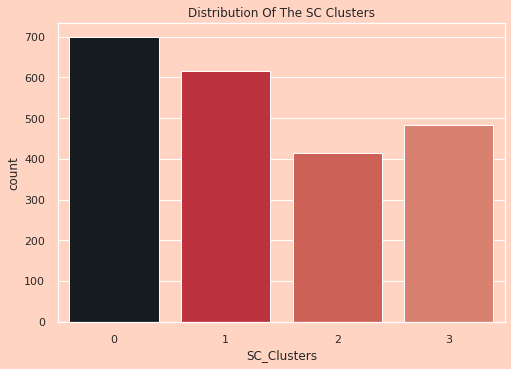

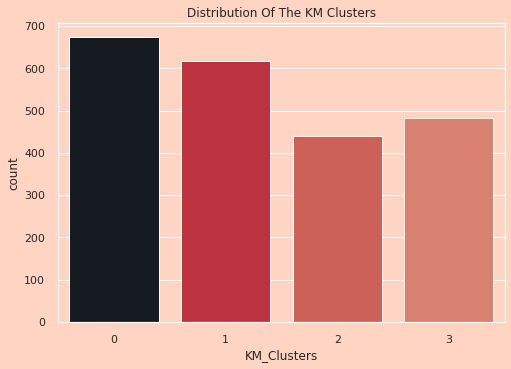

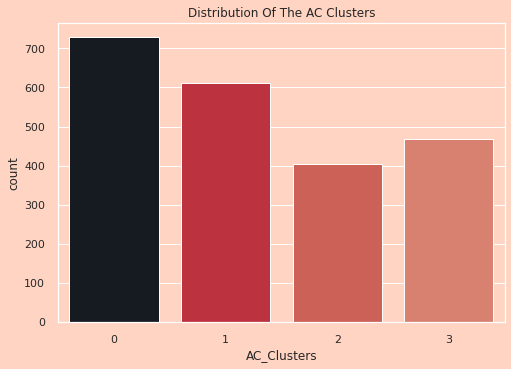

In [ ]:
#Plotting countplot of clusters
pal = ["#131B23", "#d41b2c", "#e05143", "#ea755e"]
for label in cluster_labels:
  pl = sns.countplot(x=data[label], palette= pal)
  pl.set_title(f"Distribution Of The {label.replace('_', ' ')}")
  plt.show()
  print(" ")

<AxesSubplot:>

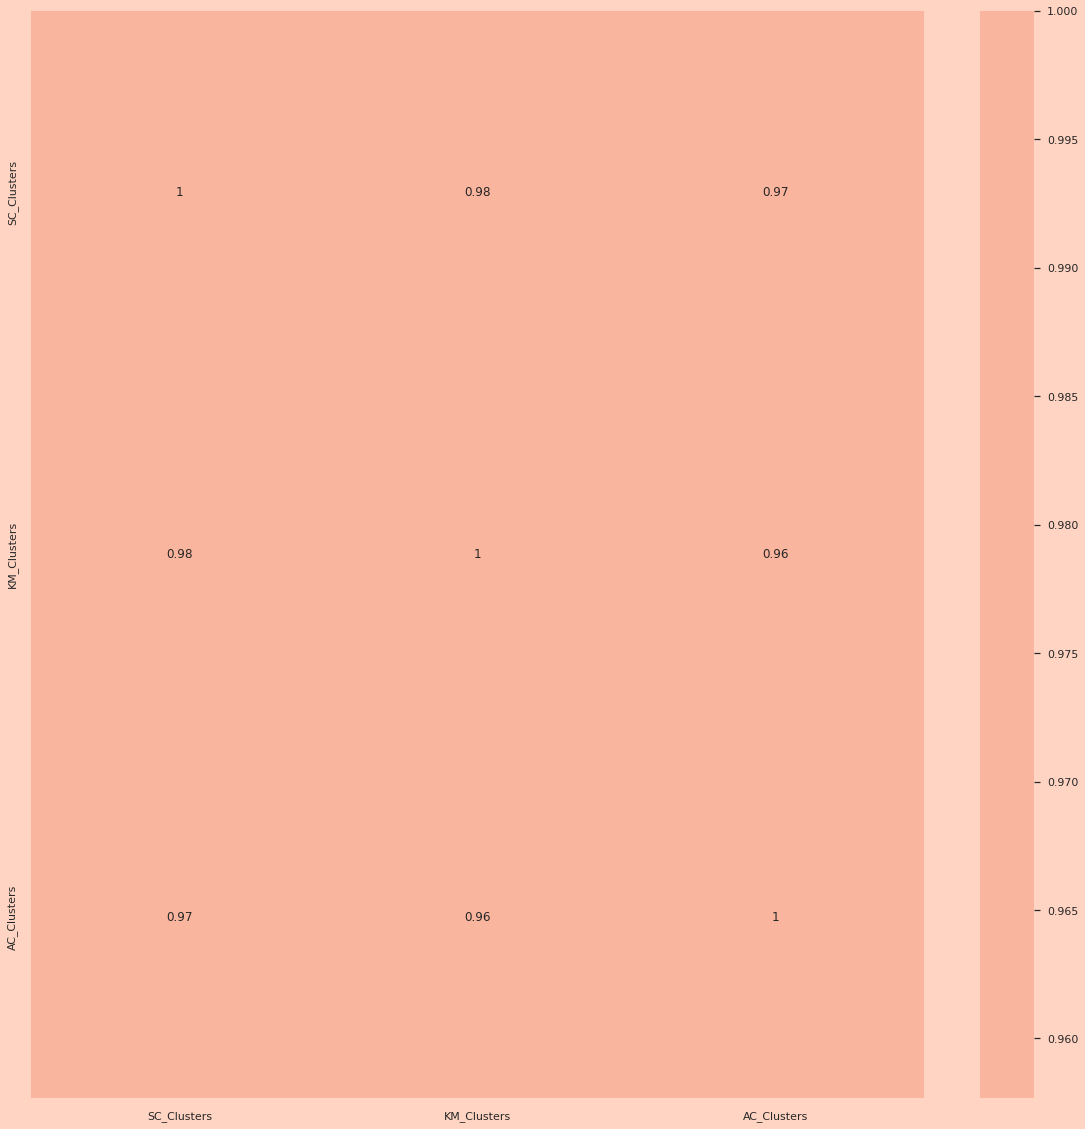

In [ ]:
clust_corrmat= data[cluster_labels].corr()
plt.figure(figsize=(20,20))  
sns.heatmap(clust_corrmat, annot=True, cmap=cmap, center=0)

There does not seem to be a meaningful difference between the classification methods, this means that the personas created from any method should be the same for each of the clustering methods which means we only need to create one persona for each cluster we select Agglomerative Clustering to create the customer personas for the segments.

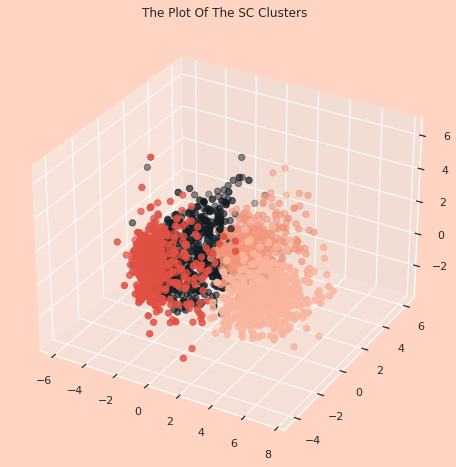

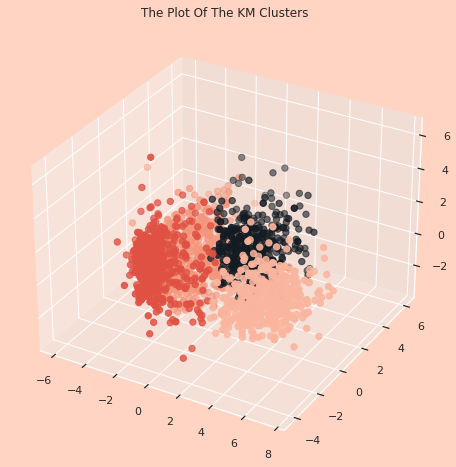

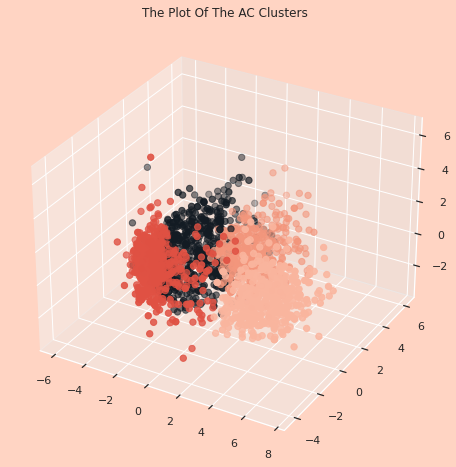

In [ ]:
#Plotting the clusters
for label in cluster_labels:
  fig = plt.figure(figsize=(10,8))
  ax = plt.subplot(111, projection='3d', label="bla")
  ax.scatter(x, y, z, s=40, c=PCA_ds[label], marker='o', cmap = cmap )
  ax.set_title(f"The Plot Of The {label.replace('_', ' ')}")
  plt.show()
  print(" ")

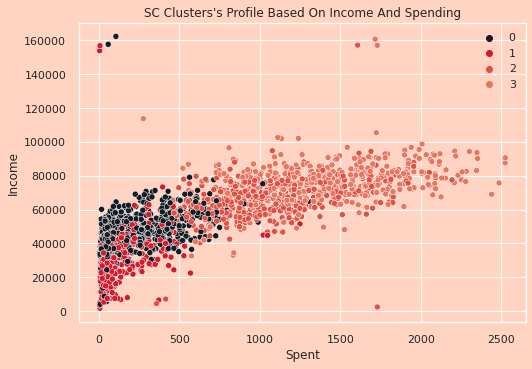

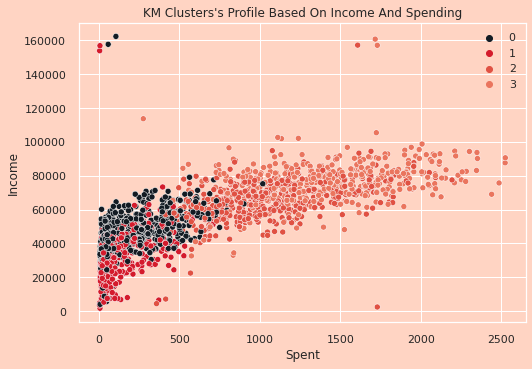

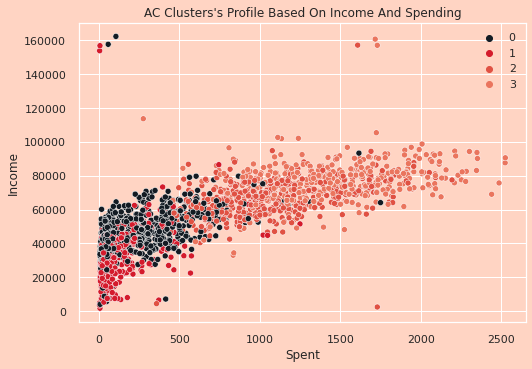

In [ ]:
for label in cluster_labels:
  pl = sns.scatterplot(data=data, x=data["Spent"], y=data["Income"],
                       hue=data[label], palette= pal)
  pl.set_title(f"{label.replace('_', ' ')}'s Profile Based On Income And Spending")
  plt.legend()
  plt.show()
  print(" ")

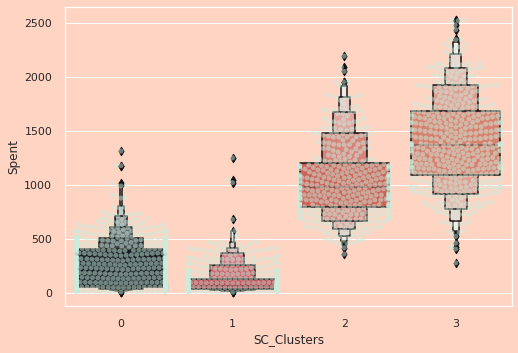

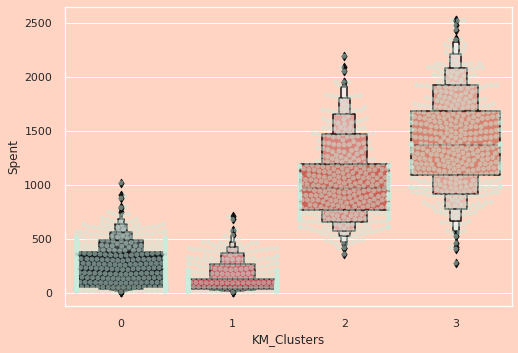

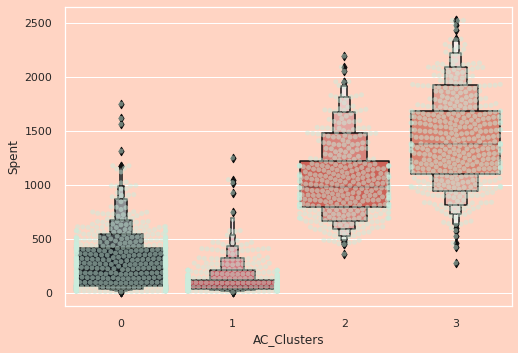

In [ ]:
for label in cluster_labels:
  plt.figure()
  pl=sns.swarmplot(x=data[label], y=data["Spent"], color= "#CBEDDD", alpha=0.5 )
  pl=sns.boxenplot(x=data[label], y=data["Spent"], palette=pal)
  plt.show()
  print(" ")

SC Clusters


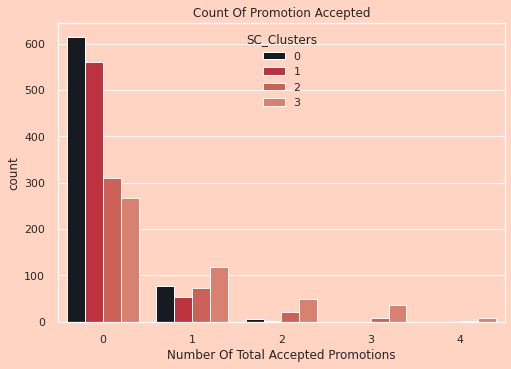

 
KM Clusters


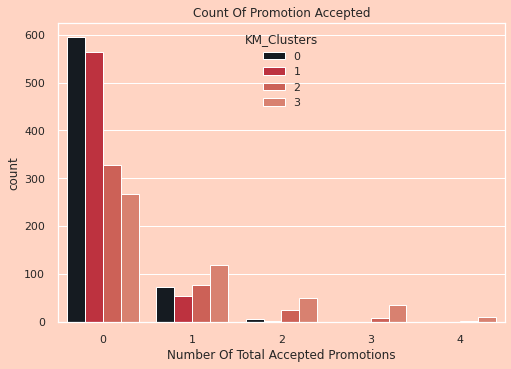

 
AC Clusters


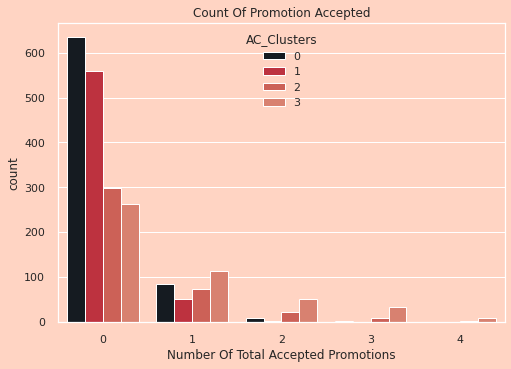

In [ ]:
#Creating a feature to get a sum of accepted promotions 
data["Total_Promos"] = data["AcceptedCmp1"]+ data["AcceptedCmp2"]+ data["AcceptedCmp3"]+ data["AcceptedCmp4"]+ data["AcceptedCmp5"]
#Plotting count of total campaign accepted.
for label in cluster_labels:
  print(label.replace("_", " "))
  plt.figure()
  pl = sns.countplot(x=data["Total_Promos"],hue=data[label], palette= pal)
  pl.set_title("Count Of Promotion Accepted")
  pl.set_xlabel("Number Of Total Accepted Promotions")
  plt.show()
  print(" ")

SC Clusters


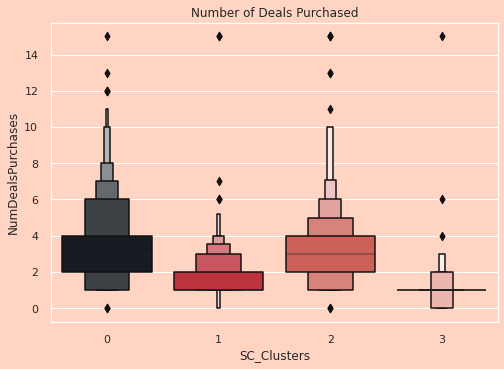

 
KM Clusters


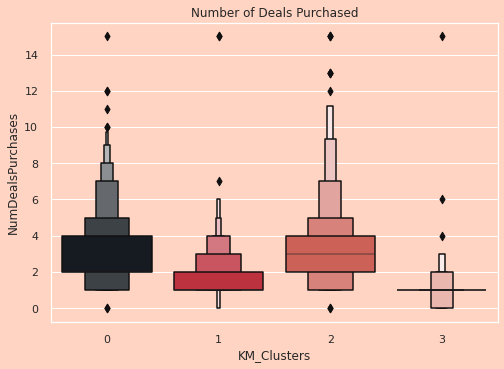

 
AC Clusters


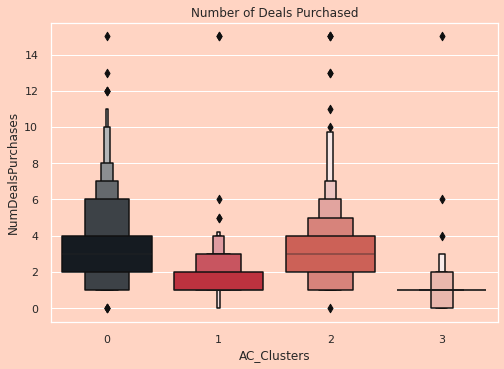

In [ ]:
#Plotting the number of deals purchased
for label in cluster_labels:
  print(label.replace("_", " "))
  plt.figure()
  pl=sns.boxenplot(y=data["NumDealsPurchases"],x=data[label], palette= pal)
  pl.set_title("Number of Deals Purchased")
  plt.show()
  print(" ")

SC Clusters
Kidhome


<Figure size 576x396 with 0 Axes>

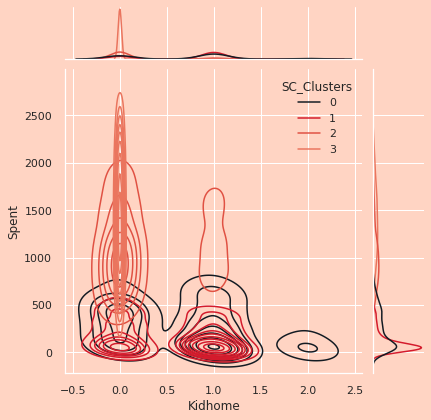

Teenhome


<Figure size 576x396 with 0 Axes>

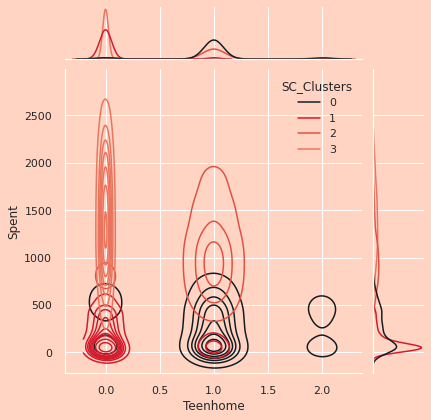

Customer For


<Figure size 576x396 with 0 Axes>

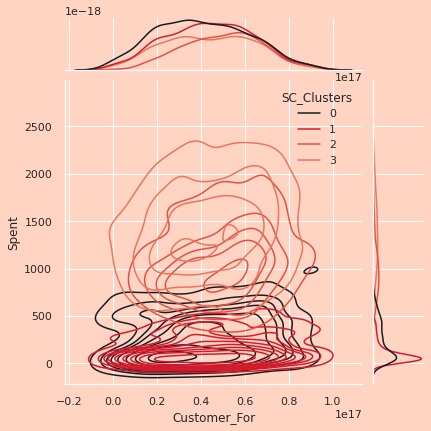

Age


<Figure size 576x396 with 0 Axes>

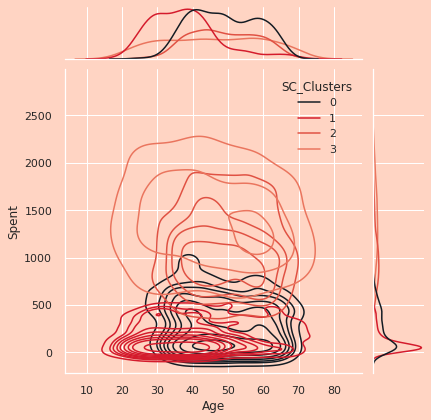

Children


<Figure size 576x396 with 0 Axes>

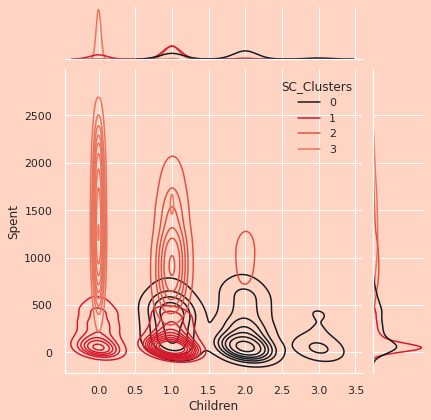

Family Size


<Figure size 576x396 with 0 Axes>

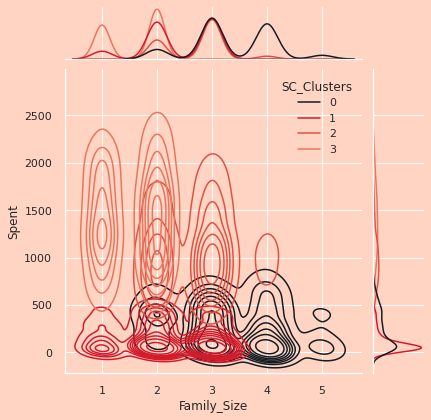

Is Parent


<Figure size 576x396 with 0 Axes>

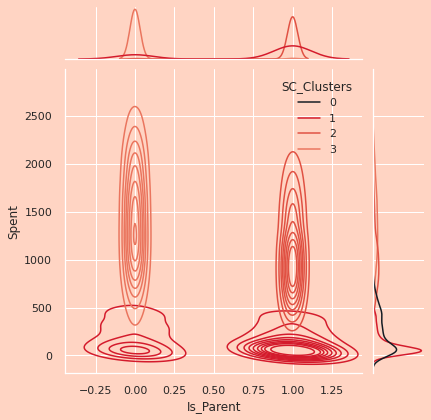

Education


<Figure size 576x396 with 0 Axes>

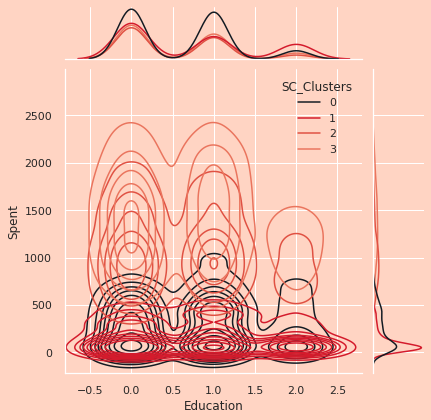

Marital Status


<Figure size 576x396 with 0 Axes>

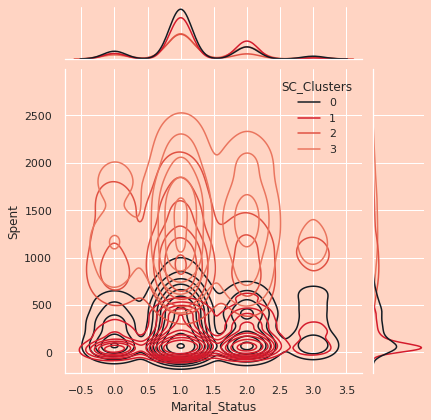

KM Clusters
Kidhome


<Figure size 576x396 with 0 Axes>

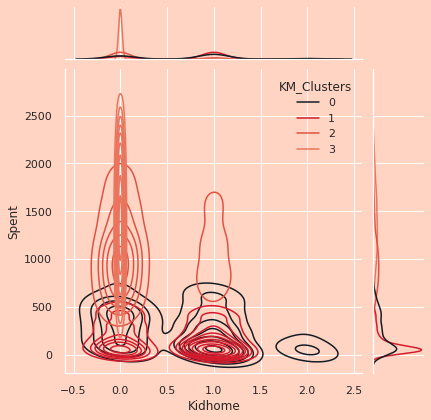

Teenhome


<Figure size 576x396 with 0 Axes>

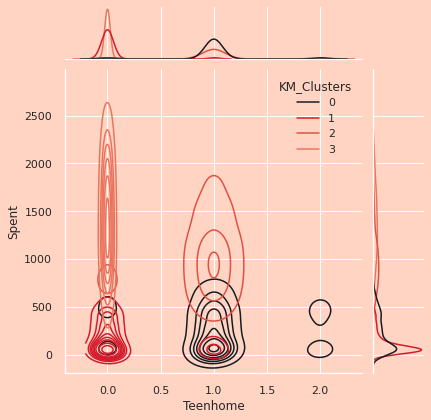

Customer For


<Figure size 576x396 with 0 Axes>

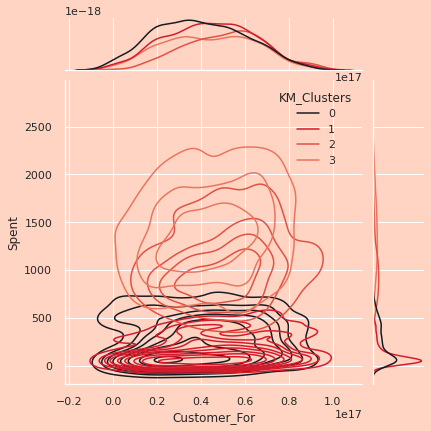

Age


<Figure size 576x396 with 0 Axes>

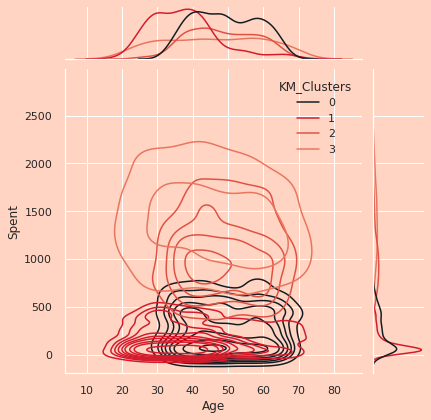

Children


<Figure size 576x396 with 0 Axes>

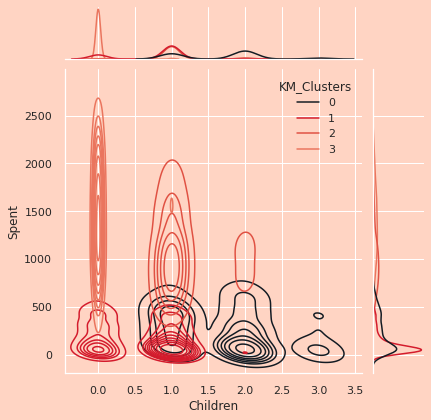

Family Size


<Figure size 576x396 with 0 Axes>

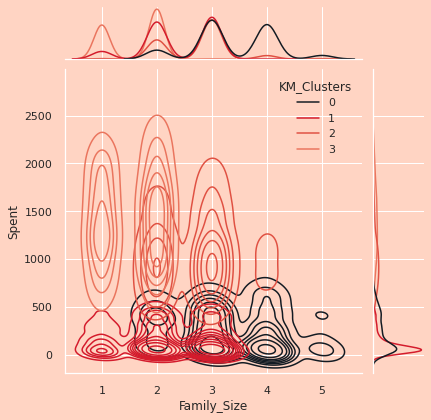

Is Parent


<Figure size 576x396 with 0 Axes>

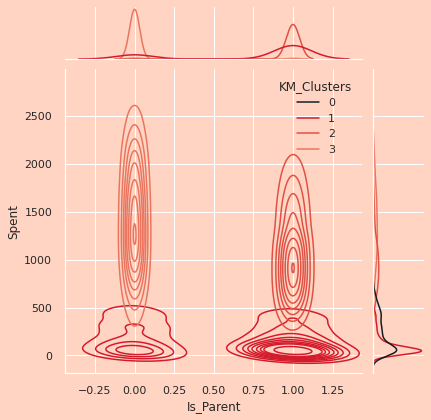

Education


<Figure size 576x396 with 0 Axes>

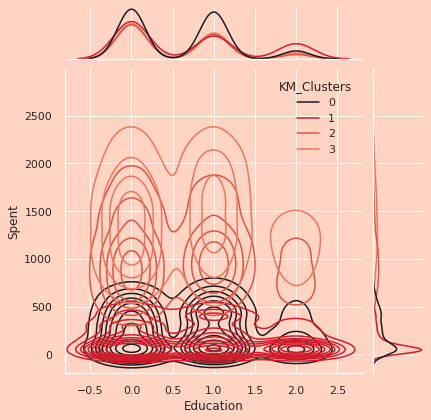

Marital Status


<Figure size 576x396 with 0 Axes>

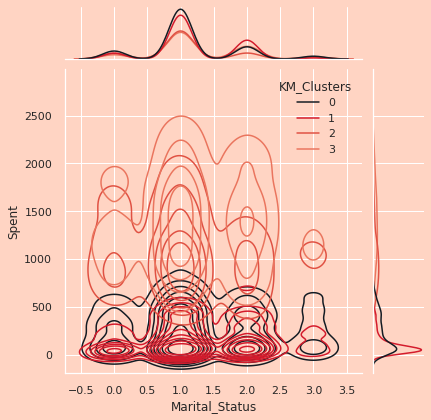

AC Clusters
Kidhome


<Figure size 576x396 with 0 Axes>

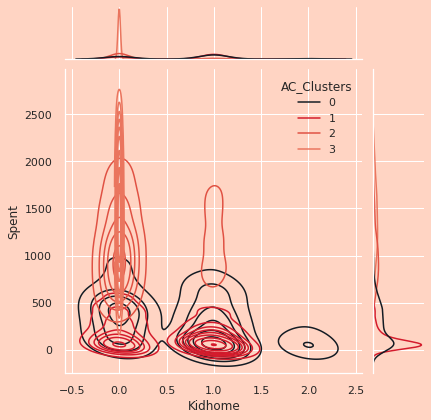

Teenhome


<Figure size 576x396 with 0 Axes>

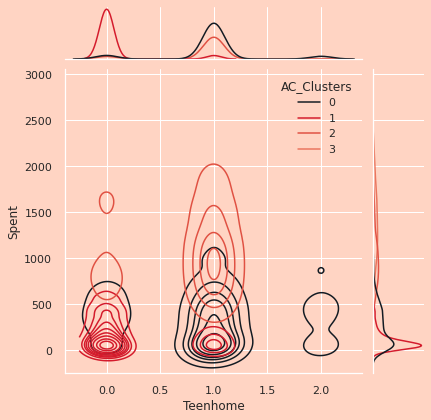

Customer For


<Figure size 576x396 with 0 Axes>

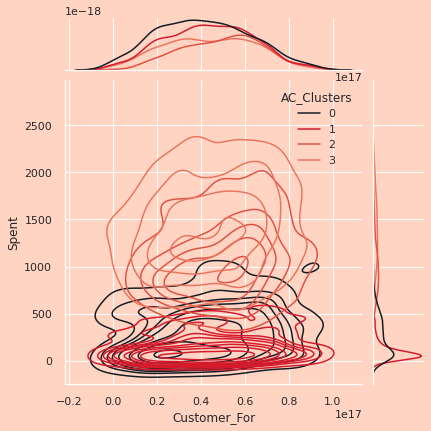

Age


<Figure size 576x396 with 0 Axes>

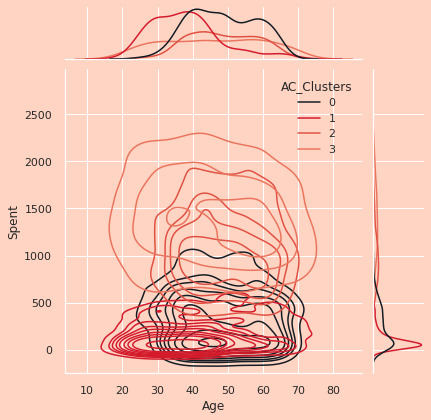

Children


<Figure size 576x396 with 0 Axes>

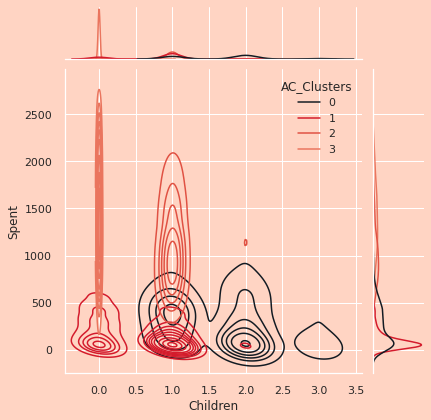

Family Size


<Figure size 576x396 with 0 Axes>

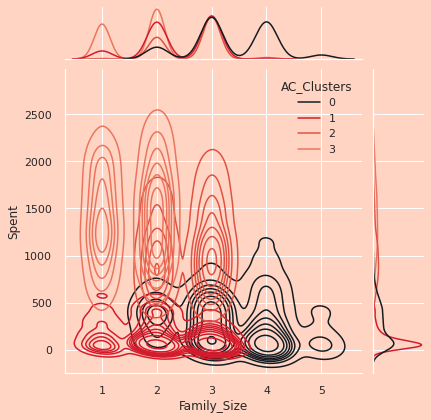

Is Parent


<Figure size 576x396 with 0 Axes>

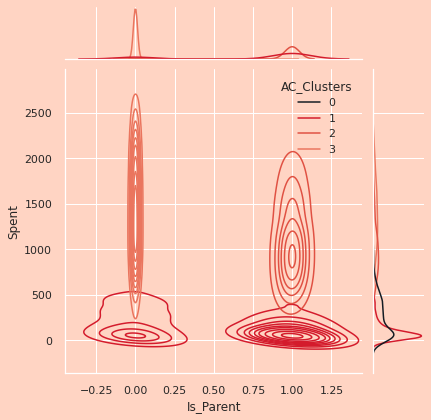

Education


<Figure size 576x396 with 0 Axes>

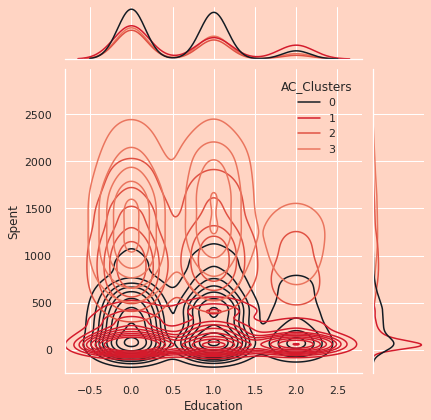

Marital Status


<Figure size 576x396 with 0 Axes>

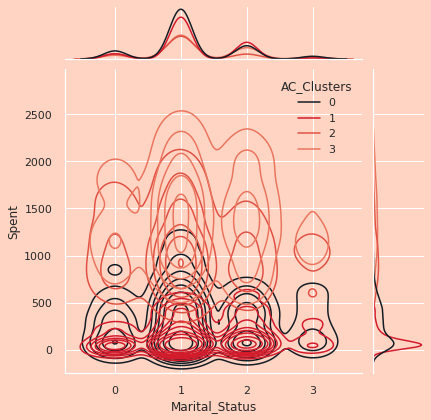

In [ ]:
Personal = [ "Kidhome","Teenhome","Customer_For", "Age", "Children", "Family_Size", "Is_Parent", "Education","Marital_Status"]
for label in cluster_labels:
  print(label.replace("_", " "))
  for i in Personal:
    print(i.replace("_", " "))
    plt.figure()
    sns.jointplot(x=data[i], y=data["Spent"], hue=data[label], kind="kde", palette=pal)
    plt.show()

In [ ]:
data.loc[data["AC_Clusters"]== 0].describe()

Education  Marital_Status    Income  Kidhome  Teenhome  Recency  \
count     729.00          729.00    729.00   729.00    729.00   729.00   
mean        0.60            1.14  46501.37     0.70      0.98    48.47   
std         0.63            0.65  13863.19     0.57      0.39    29.10   
min         0.00            0.00   4023.00     0.00      0.00     0.00   
25%         0.00            1.00  37758.00     0.00      1.00    24.00   
50%         1.00            1.00  46098.00     1.00      1.00    49.00   
75%         1.00            1.00  54456.00     1.00      1.00    73.00   
max         2.00            3.00 162397.00     2.00      2.00    99.00   

       SpentOnWines  SpentOnFruits  SpentOnMeat  SpentOnFish  ...  \
count        729.00         729.00       729.00       729.00  ...   
mean         165.08           7.86        52.43        10.40  ...   
std          185.53          14.16        56.68        15.73  ...   
min            1.00           0.00         1.00         0.00  ...   
25%           28.00           0.00        12.00         0.00  ...   
50%           98.00           3.00        32.00         4.00  ...   
75%          238.00           9.00        76.00        13.00  ...   
max         1459.00         123.00       487.00       123.00  ...   

              Customer_For  Children    Age   Spent  Family_Size  Is_Parent  \
count               729.00    729.00 729.00  729.00       729.00     729.00   
mean  41513718518518520.00      1.68  48.58  270.84         3.35       1.00   
std   20828640430642868.00      0.59   9.49  254.63         0.75       0.00   
min      86400000000000.00      1.00  24.00    8.00         2.00       1.00   
25%   25228800000000000.00      1.00  41.00   61.00         3.00       1.00   
50%   40867200000000000.00      2.00  48.00  211.00         3.00       1.00   
75%   56419200000000000.00      2.00  57.00  417.00         4.00       1.00   
max   91670400000000000.00      3.00  68.00 1750.00         5.00       1.00   

       AC_Clusters  KM_Clusters  SC_Clusters  Total_Promos  
count       729.00       729.00       729.00        729.00  
mean          0.00         0.16         0.09          0.14  
std           0.00         0.50         0.38          0.39  
min           0.00         0.00         0.00          0.00  
25%           0.00         0.00         0.00          0.00  
50%           0.00         0.00         0.00          0.00  
75%           0.00         0.00         0.00          0.00  
max           0.00         2.00         2.00          3.00  

[8 rows x 34 columns]

In [ ]:
data.loc[data["AC_Clusters"]== 1].describe() 

Education  Marital_Status    Income  Kidhome  Teenhome  Recency  \
count     612.00          612.00    612.00   612.00    612.00   612.00   
mean        0.72            1.21  30721.14     0.69      0.07    48.46   
std         0.78            0.60  13539.35     0.47      0.25    28.68   
min         0.00            0.00   1730.00     0.00      0.00     0.00   
25%         0.00            1.00  22492.25     0.00      0.00    24.00   
50%         1.00            1.00  30007.00     1.00      0.00    48.00   
75%         1.00            2.00  37702.00     1.00      0.00    74.00   
max         2.00            3.00 156924.00     2.00      1.00    99.00   

       SpentOnWines  SpentOnFruits  SpentOnMeat  SpentOnFish  ...  \
count        612.00         612.00       612.00       612.00  ...   
mean          39.94           7.06        25.90        10.58  ...   
std           89.56          12.00        31.93        19.42  ...   
min            0.00           0.00         0.00         0.00  ...   
25%            5.00           1.00         8.00         2.00  ...   
50%           14.00           3.00        15.00         4.00  ...   
75%           37.00           8.00        28.00        12.00  ...   
max         1166.00         151.00       226.00       179.00  ...   

              Customer_For  Children    Age   Spent  Family_Size  Is_Parent  \
count               612.00    612.00 612.00  612.00       612.00     612.00   
mean  43930447058823528.00      0.75  38.07  107.76         2.40       0.75   
std   19587608521829800.00      0.45  10.16  134.38         0.65       0.44   
min                   0.00      0.00  18.00    5.00         1.00       0.00   
25%   29721600000000000.00      0.00  30.00   37.00         2.00       0.00   
50%   44193600000000000.00      1.00  37.00   62.00         2.00       1.00   
75%   58168800000000000.00      1.00  43.00  122.00         3.00       1.00   
max   91843200000000000.00      2.00  74.00 1250.00         4.00       1.00   

       AC_Clusters  KM_Clusters  SC_Clusters  Total_Promos  
count       612.00       612.00       612.00        612.00  
mean          1.00         0.99         0.99          0.09  
std           0.00         0.25         0.23          0.30  
min           1.00         0.00         0.00          0.00  
25%           1.00         1.00         1.00          0.00  
50%           1.00         1.00         1.00          0.00  
75%           1.00         1.00         1.00          0.00  
max           1.00         3.00         3.00          2.00  

[8 rows x 34 columns]

In [ ]:
data.loc[data["AC_Clusters"]== 2].describe() 

Education  Marital_Status    Income  Kidhome  Teenhome  Recency  \
count     403.00          403.00    403.00   403.00    403.00   403.00   
mean        0.51            1.09  65504.54     0.11      0.91    51.05   
std         0.63            0.68  11365.19     0.32      0.32    28.69   
min         0.00            0.00   2447.00     0.00      0.00     0.00   
25%         0.00            1.00  58631.50     0.00      1.00    27.00   
50%         0.00            1.00  64866.00     0.00      1.00    51.00   
75%         1.00            1.00  71909.00     0.00      1.00    77.00   
max         2.00            3.00 157243.00     2.00      2.00    99.00   

       SpentOnWines  SpentOnFruits  SpentOnMeat  SpentOnFish  ...  \
count        403.00         403.00       403.00       403.00  ...   
mean         593.74          42.86       221.39        59.77  ...   
std          301.81          42.43       162.47        60.16  ...   
min            1.00           0.00        12.00         0.00  ...   
25%          371.00          12.00       124.00        13.00  ...   
50%          543.00          30.00       186.00        42.00  ...   
75%          782.00          62.00       279.00        85.50  ...   
max         1492.00         199.00      1725.00       259.00  ...   

              Customer_For  Children    Age   Spent  Family_Size  Is_Parent  \
count               403.00    403.00 403.00  403.00       403.00     403.00   
mean  50159809429280400.00      1.01  48.57 1041.11         2.68       0.98   
std   18158858361166488.00      0.26   9.47  347.94         0.53       0.16   
min      86400000000000.00      0.00  25.00  359.00         1.00       0.00   
25%   36892800000000000.00      1.00  41.00  793.50         2.00       1.00   
50%   51753600000000000.00      1.00  48.00  982.00         3.00       1.00   
75%   63244800000000000.00      1.00  56.00 1218.50         3.00       1.00   
max   91843200000000000.00      3.00  70.00 2194.00         4.00       1.00   

       AC_Clusters  KM_Clusters  SC_Clusters  Total_Promos  
count       403.00       403.00       403.00        403.00  
mean          2.00         2.02         2.02          0.37  
std           0.00         0.16         0.16          0.73  
min           2.00         2.00         2.00          0.00  
25%           2.00         2.00         2.00          0.00  
50%           2.00         2.00         2.00          0.00  
75%           2.00         2.00         2.00          1.00  
max           2.00         3.00         3.00          4.00  

[8 rows x 34 columns]

In [ ]:
data.loc[data["AC_Clusters"]== 3].describe() 

Education  Marital_Status    Income  Kidhome  Teenhome  Recency  \
count     468.00          468.00    468.00   468.00    468.00   468.00   
mean        0.56            1.28  76567.78     0.00      0.00    48.85   
std         0.65            0.69  11858.59     0.05      0.00    29.28   
min         0.00            0.00  33051.00     0.00      0.00     0.00   
25%         0.00            1.00  70038.00     0.00      0.00    23.00   
50%         0.00            1.00  76912.00     0.00      0.00    51.50   
75%         1.00            2.00  82577.50     0.00      0.00    73.00   
max         2.00            3.00 160803.00     1.00      0.00    99.00   

       SpentOnWines  SpentOnFruits  SpentOnMeat  SpentOnFish  ...  \
count        468.00         468.00       468.00       468.00  ...   
mean         622.29          66.06       483.29        96.44  ...   
std          317.31          50.91       244.23        64.83  ...   
min            1.00           0.00         3.00         0.00  ...   
25%          375.00          25.00       304.75        42.00  ...   
50%          580.00          51.00       447.00        84.00  ...   
75%          847.25         101.25       658.75       145.00  ...   
max         1493.00         197.00      1725.00       254.00  ...   

              Customer_For  Children    Age   Spent  Family_Size  Is_Parent  \
count               468.00    468.00 468.00  468.00       468.00     468.00   
mean  43837661538461536.00      0.00  45.83 1410.92         1.59       0.00   
std   20176279157405988.00      0.05  14.17  420.10         0.49       0.05   
min      86400000000000.00      0.00  19.00  277.00         1.00       0.00   
25%   28231200000000000.00      0.00  33.00 1101.75         1.00       0.00   
50%   43848000000000000.00      0.00  45.00 1375.50         2.00       0.00   
75%   59551200000000000.00      0.00  58.00 1686.50         2.00       0.00   
max   91843200000000000.00      1.00  73.00 2525.00         2.00       1.00   

       AC_Clusters  KM_Clusters  SC_Clusters  Total_Promos  
count       468.00       468.00       468.00        468.00  
mean          3.00         3.00         3.00          0.75  
std           0.00         0.00         0.00          1.03  
min           3.00         3.00         3.00          0.00  
25%           3.00         3.00         3.00          0.00  
50%           3.00         3.00         3.00          0.00  
75%           3.00         3.00         3.00          1.00  
max           3.00         3.00         3.00          4.00  

[8 rows x 34 columns]